# WealthNaviのポートフォリオ最適化

#### 参考URL: https://datacoach.me/investment/long-inv/python-wealthnavi/



[WealthNaviの資産運用アルゴリズム](https://www.wealthnavi.com/image/WealthNavi_WhitePaper.pdf)
- 平均分散法によって資産クラスの最適化を行う
- リスク許容度に応じた最適ポートフォリオは以下の（非線形）最大化問題の解となる資産配分比率(w)を求めることによって求まる

$$
max(\mathbf{w})  \quad  \mathbf{r^T w} - \frac{1}{2 \lambda} \mathbf{w^T \Sigma w} \\
s.t.  \  \mathbf{w^T 1}=1,  \  a \leqq \mathbf{w} \leqq b \\
$$  

$$
\begin{align}
  & \mathbf{r}: & &各資産クラスの期待リターン  \\
  & \mathbf{\Sigma}: & &分散・共分散行列  \\
  & \mathbf{w}: & &各資産クラスへの配分比率  \\
  & \mathbf{\lambda}: & &リスク許容度（1 - 5）に応じた係数  \\
  & \mathbf{a}: & &各銘柄への配分比率の下限  \\
  & \mathbf{b}: & &各銘柄への配分比率の上限  \\
\end{align}
$$ 



#### 線形・非線形問題
https://ajhjhaf.hatenablog.com/entry/2018/02/12/235015  
https://ki-chi.jp/?p=582  
https://longtweets.hatenablog.com/entry/2019/01/04/055820

- PULP　（線形問題のみ）  
    - https://coin-or.github.io/pulp/
    - https://docs.pyq.jp/python/math_opt/pulp.html
    - https://qiita.com/SaitoTsutomu/items/070ca9cb37c6b2b492f0
- CYXOPT（非線形問題に対応）
    - http://cvxopt.org/index.html
    - https://qiita.com/ryoshi81/items/8b0c6add3e367f94c828
- PyPortfolioOpt　（ポートフォリオ最適化問題に特化したパッケージ）
    - https://pyportfolioopt.readthedocs.io/en/latest/index.html
    - https://qiita.com/ryoshi81/items/c2445a5705b495002c1d
    

In [1]:
%matplotlib inline
import os, sys, math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pypfopt.efficient_frontier import EfficientFrontier

## Load data

In [2]:
# correlations between asset classes

S = pd.read_csv('assetclass_correlation_202002.csv', index_col=0)

In [3]:
S

,Stock-US,Stock-Jpn/EU,Stock-Emerging,Bonds-US,Bonds-PriceLinked,Gold,RealEstate
Class,,,,,,,
Stock-US,1.0,0.9,0.7,-0.2,0.0,0.0,0.6
Stock-Jpn/EU,0.9,1.0,0.8,-0.1,0.1,0.1,0.6
Stock-Emerging,0.7,0.8,1.0,0.0,0.2,0.3,0.5
Bonds-US,-0.2,-0.1,0.0,1.0,0.8,0.4,0.3
Bonds-PriceLinked,0.0,0.1,0.2,0.8,1.0,0.5,0.4
Gold,0.0,0.1,0.3,0.4,0.5,1.0,0.1
RealEstate,0.6,0.6,0.5,0.3,0.4,0.1,1.0


In [4]:
S.index

Index(['Stock-US', 'Stock-Jpn/EU', 'Stock-Emerging', 'Bonds-US',
       'Bonds-PriceLinked', 'Gold', 'RealEstate'],
      dtype='object', name='Class')

In [5]:
S = S.drop(index='Bonds-PriceLinked').drop('Bonds-PriceLinked', axis='columns')
S

,Stock-US,Stock-Jpn/EU,Stock-Emerging,Bonds-US,Gold,RealEstate
Class,,,,,,
Stock-US,1.0,0.9,0.7,-0.2,0.0,0.6
Stock-Jpn/EU,0.9,1.0,0.8,-0.1,0.1,0.6
Stock-Emerging,0.7,0.8,1.0,0.0,0.3,0.5
Bonds-US,-0.2,-0.1,0.0,1.0,0.4,0.3
Gold,0.0,0.1,0.3,0.4,1.0,0.1
RealEstate,0.6,0.6,0.5,0.3,0.1,1.0


In [6]:
cor = S.values
#print(S.shape)

In [7]:
cor

array([[ 1. ,  0.9,  0.7, -0.2,  0. ,  0.6],
       [ 0.9,  1. ,  0.8, -0.1,  0.1,  0.6],
       [ 0.7,  0.8,  1. ,  0. ,  0.3,  0.5],
       [-0.2, -0.1,  0. ,  1. ,  0.4,  0.3],
       [ 0. ,  0.1,  0.3,  0.4,  1. ,  0.1],
       [ 0.6,  0.6,  0.5,  0.3,  0.1,  1. ]])

In [8]:
name = list(S.columns.values)

In [9]:
name

['Stock-US',
 'Stock-Jpn/EU',
 'Stock-Emerging',
 'Bonds-US',
 'Gold',
 'RealEstate']

In [10]:
# risk of each class

risk = {}
risk["Stock-US"] = 12.5/100
risk["Stock-Jpn/EU"] = 13.6/100
risk["Stock-Emerging"] = 16.7/100
risk["Bonds-US"] = 3.1/100
#risk["Bonds-PriceLinked"] = 4.1/100
risk["Gold"] = 15.0/100
risk["RealEstate"] = 13.4/100

In [11]:
# convert to numpy array

risk = np.array(list(risk.values()))
#risk = risk.reshape(len(risk),1)
#print(risk.shape)

In [12]:
risk

array([0.125, 0.136, 0.167, 0.031, 0.15 , 0.134])

In [13]:
# expected return from each class

val = {}
val["Stock-US"] = 7.2/100
val["Stock-Jpn/EU"] = 7.7/100
val["Stock-Emerging"] = (8.5+0.00000000001)/100
val["Bonds-US"] = 2.3/100
#val["Bonds-PriceLinked"] = 2.6/100
val["Gold"] = 3.8/100
val["RealEstate"] = 5.7/100

In [14]:
# convert to numpy array

val = np.array(list(val.values()))
#val = val.reshape(len(val),1)
#print(val.shape)

In [15]:
val

array([0.072, 0.077, 0.085, 0.023, 0.038, 0.057])

## Diagonalize risk vector and obtain covariance matrix using correlation matrix

In [16]:
r_diag = np.diag(risk)

In [17]:
r_diag

array([[0.125, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.136, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.167, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.031, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.15 , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.134]])

In [18]:
cov = np.dot(np.dot(r_diag, cor), r_diag)

In [19]:
cov

array([[ 0.015625 ,  0.0153   ,  0.0146125, -0.000775 ,  0.       ,
         0.01005  ],
       [ 0.0153   ,  0.018496 ,  0.0181696, -0.0004216,  0.00204  ,
         0.0109344],
       [ 0.0146125,  0.0181696,  0.027889 ,  0.       ,  0.007515 ,
         0.011189 ],
       [-0.000775 , -0.0004216,  0.       ,  0.000961 ,  0.00186  ,
         0.0012462],
       [ 0.       ,  0.00204  ,  0.007515 ,  0.00186  ,  0.0225   ,
         0.00201  ],
       [ 0.01005  ,  0.0109344,  0.011189 ,  0.0012462,  0.00201  ,
         0.017956 ]])

In [20]:
df = pd.DataFrame(cov, index = name, columns=name)
df

,Stock-US,Stock-Jpn/EU,Stock-Emerging,Bonds-US,Gold,RealEstate
Stock-US,0.015625,0.015300,0.014612,-0.000775,0.000000,0.010050
Stock-Jpn/EU,0.015300,0.018496,0.018170,-0.000422,0.002040,0.010934
Stock-Emerging,0.014612,0.018170,0.027889,0.000000,0.007515,0.011189
Bonds-US,-0.000775,-0.000422,0.000000,0.000961,0.001860,0.001246
Gold,0.000000,0.002040,0.007515,0.001860,0.022500,0.002010
RealEstate,0.010050,0.010934,0.011189,0.001246,0.002010,0.017956


## Optimize asset classes with upper and lower bounds (weights of each asset class must be between 5% ~ 35%)

In [21]:
# 資産クラスの重みを一律に5% ~ 35%に設定
ef = EfficientFrontier(val, df, weight_bounds=(0.05, 0.35))

In [22]:
coeff = 0.3

sigma = 1/coeff
print("sigma: {}".format(sigma))

weights = ef.max_quadratic_utility(risk_aversion= sigma)

sigma: 3.3333333333333335


In [23]:
weights

OrderedDict([('Stock-US', 0.35),
             ('Stock-Jpn/EU', 0.2515115769744572),
             ('Stock-Emerging', 0.2484884230255429),
             ('Bonds-US', 0.05),
             ('Gold', 0.05),
             ('RealEstate', 0.05)])

In [24]:
ef.portfolio_performance(verbose=True, risk_free_rate=0.02)

Expected annual return: 7.2%
Annual volatility: 11.6%
Sharpe Ratio: 0.44


(0.0715879073842292, 0.11639116150819273, 0.44322873589158174)

In [25]:
v = list(weights.values())
print(v)

[0.35, 0.2515115769744572, 0.2484884230255429, 0.05, 0.05, 0.05]


In [26]:
label = list(df.columns)
print(label)

['Stock-US', 'Stock-Jpn/EU', 'Stock-Emerging', 'Bonds-US', 'Gold', 'RealEstate']


In [27]:
# fontsize: xx-small, x-small, small, medium, large, x-large, xx-large
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 4),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
#plt.rcParams.update(plt.rcParamsDefault)

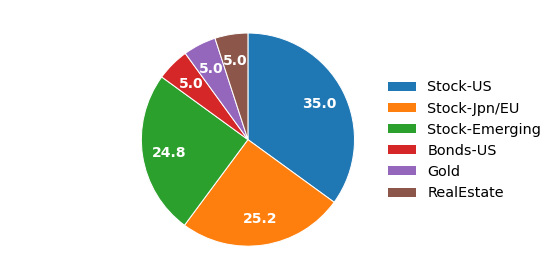

In [28]:
plt.pie(v, labels=label, counterclock=False, startangle=90,
        labeldistance=1.1, 
        autopct=lambda p:'{:.1f}'.format(p), 
        #autopct="%1.1f%%",
        pctdistance=0.75, 
        textprops={'color': "white", 'weight': "bold", 'fontsize': "14"},
        wedgeprops={'linewidth': 1, 'edgecolor':"white"})

plt.legend(bbox_to_anchor=(1.0, 0.25, 1.50, 0.5), loc="center left", borderaxespad=0., frameon=False)
plt.tight_layout()

plt.savefig("wealthnavi_opt_portfolio_with_bounds_lambda_0.3.png")
#plt.show()